## TensorFlow ProfilerとTensorBoard

In [1]:
pip install -U tensorboard-plugin-profile

In [2]:
import tensorflow as tf


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train/255.
x_test = x_test/255.

model = tf.keras.models.Sequential((
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", profile_batch=7)

model.fit(x_train, y_train, epochs=2, callbacks=[tensorboard_callback])

Epoch 1/2
1563/1563 [==============================] - 14s 8ms/step - loss: 1.5854
Epoch 2/2
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2173


ローカルで実行している場合は、 `tensorboard` コマンドを実行してください。Google Colaboratory を利用している場合は、以下のコードで TensorBoeard を起動し、ノートブック内に表示できます。

In [3]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 157), started 1:03:39 ago. (Use '!kill 157' to kill it.)

<IPython.core.display.Javascript object>

## データの準備

以下のコードは原著の[サンプルコード](https://github.com/PracticalDL/Practical-Deep-Learning-Book/blob/master/code/chapter-6/storing-data-as-tfrecord.ipynb)を日本語版に合わせて修正したものです。

In [4]:
# 画像ファイルをダウンロード
!curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/cat.jpg --output cat.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  661k  100  661k    0     0  2689k      0 --:--:-- --:--:-- --:--:-- 2689k


In [5]:
import tensorflow as tf
from PIL import Image
import numpy as np
import io

cat = "cat.jpg"
img_name_to_labels = {cat: 0}
img_in_string = open(cat, 'rb').read()
label_for_img = img_name_to_labels[cat]

# 下記の関数を使うと値を tf.Example と互換性の有る型に変換できる

def _bytes_feature(value):
  """string / byte 型から byte_list を返す"""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """float / double 型から float_list を返す"""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """bool / enum / int / uint 型から Int64_list を返す"""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def get_tfrecord(img, label):
 feature = {
    'label': _int64_feature(label),
    'image_raw': _bytes_feature(img),
 }
 return tf.train.Example(features=tf.train.Features(feature=feature))

with tf.io.TFRecordWriter('img.tfrecord') as writer:
  for filename, label in img_name_to_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = get_tfrecord(image_string, label)
    writer.write(tf_example.SerializeToString())

In [6]:
# img.tfrecord が生成されていることを確認
!ls

cat.jpg  img.tfrecord  logs  sample_data  tmp.h5  training_data


In [7]:
# TFRecordファイルの読み込み

dataset = tf.data.TFRecordDataset('img.tfrecord')
ground_truth_info = {
  'label': tf.compat.v1.FixedLenFeature([], tf.int64),
  'image_raw': tf.compat.v1.FixedLenFeature([], tf.string),
}

def map_operation(read_data):
  return tf.compat.v1.parse_single_example(read_data, ground_truth_info)

imgs = dataset.map(map_operation)

for image_features in imgs:
  image_raw = image_features['image_raw'].numpy()
  label = image_features['label'].numpy()
  image = Image.open(io.BytesIO(image_raw))
  image.show()
  print(label)

0


## TensorFlow Datasetsを利用する

In [8]:
import tensorflow_datasets as tfds

# 利用可能なデータセットを表示します
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_r

In [9]:
train_dataset = tfds.load(name="cifar100", split=tfds.Split.TRAIN)
train_dataset = train_dataset.shuffle(2048).batch(64)

## tf.data を利用する

以下のコードを実行するには、`training_data` ディレクトリ以下に訓練データセットが保存されている必要があります。ここでは、 **TensorFlow Datasetsを利用する** でダウンロードした cifar100 データセットを用います

In [10]:
# ダウンロードした cifar100 データセットから tfrecord をコピーする
!mkdir -p training_data
!cp ~/tensorflow_datasets/cifar100/*/cifar100-train.tfrecord* training_data/cifar100-train.tfrecord

In [11]:
features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

def preprocess(example):
    data = tf.io.parse_single_example(example, features=features)
    image = data['image']
    label = data['label']

    # image は正規化する
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [12]:
files = tf.data.Dataset.list_files("./training_data/*.tfrecord")
dataset = tf.data.TFRecordDataset(files)

dataset = dataset.shuffle(2048) \
                 .repeat() \
                 .map(preprocess) \
                 .batch(64)

In [13]:
options = tf.data.Options()
options.experimental_deterministic = False
# options.experimental_optimization.filter_fusion = True
# options.experimental_optimization.map_and_filter_fusion = True
# options.experimental_optimization.map_fusion = True

dataset = tf.data.Dataset.list_files("./training_data/*.tfrecord")
dataset = dataset.with_options(options)
dataset = files.interleave(tf.data.TFRecordDataset,
                            num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(preprocess,
                            num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache() 
dataset = dataset.repeat() 
dataset = dataset.shuffle(2048)
dataset = dataset.batch(batch_size=64) 
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 最適な学習率を見つける

In [14]:
pip install keras_lr_finder

Epoch 1/5
98/98 [==============================] - 4s 34ms/step - loss: 1.0300
Epoch 2/5
98/98 [==============================] - 3s 30ms/step - loss: 0.9985
Epoch 3/5
98/98 [==============================] - 3s 30ms/step - loss: 1.8998
Epoch 4/5
98/98 [==============================] - 3s 30ms/step - loss: 2.3069
Epoch 5/5
98/98 [==============================] - 3s 30ms/step - loss: 2.3819


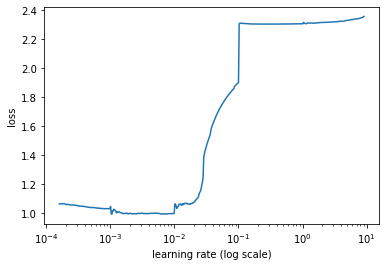

In [15]:
from keras_lr_finder import LRFinder

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=10, batch_size=512,
               epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

## tf.functionを利用する

In [16]:
import timeit


conv_layer = tf.keras.layers.Conv2D(224, 3)

def non_tf_func(image):
  for _ in range(1,3):
        conv_layer(image)
  return

@tf.function
def tf_func(image):
  for _ in range(1,3):
        conv_layer(image)
  return

mat = tf.zeros([1, 100, 100, 100])

# ウォームアップ
non_tf_func(mat)
tf_func(mat)

print("Without @tf.function:", timeit.timeit(lambda: non_tf_func(mat),
      number=10000), " seconds")
print("With @tf.function:", timeit.timeit(lambda: tf_func(mat), number=10000),
      "seconds")

Without @tf.function: 62.75666024800012  seconds
With @tf.function: 4.026196660000096 seconds
